The goal of this notebook is to use some classes and functions I wrote to compare the behaviour of polynomial least squares regression when using a monomial basis vs an orthogonal one. For the orthogonal polynomials we'll be using the Chebyshev polynomials. To start let's look at the first 5 monomials and the first 5 Chebyshev polynomials over the interval [-1, 1]

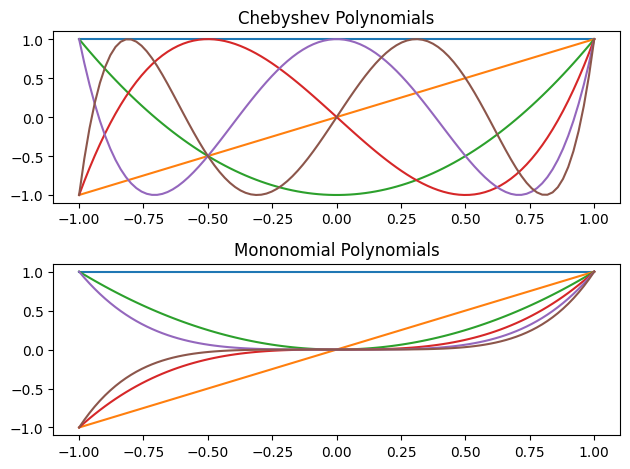

In [1]:
import matplotlib.pyplot as plt
import Poly_Regression as pr
import numpy as np
import polynomial_basis as pb
import numpy.polynomial.polynomial as p

c = pb.Chebyshev_Polynomials(6)
m = pb.monomials(6)

x = np.linspace(-1, 1, 100)
y1 = [p.polyval(x, a) for a in c]
y2 = [p.polyval(x, a) for a in m]

fig, axs = plt.subplots(2, 1)
for i in range(6):
    axs[0].plot(x, y1[i])
    axs[1].plot(x, y2[i])
axs[0].set_title('Chebyshev Polynomials')
axs[1].set_title('Mononomial Polynomials')
plt.tight_layout()

Notice how distinct the Chebyshev polynomials are compared to the monomials. This is the source of a lot of issues when using polynomials in spectral methods, using monomials in those methods can lead to "nearly singular" matricies that cause numerical issues.

For our testing we'll use each basis to do polynomial regression on some synthetic data. We'll start by comparing some exact solution methods then we'll move to comparing the performance when using iterative methods.

We'll first use NumPy's least squares function to find the least squares minimizers:

original coefficients: [-3  0  0  2  1  2]

monomial coefficients: [-2.97828746  0.24647014 -0.40498861  0.88801841  1.45789234  3.00317574]

chebyshev coefficients: [-2.71896476  2.39869885  0.41180205  0.9815214   0.15143012  0.157434  ]

chebyshev converted to monomial: [-2.97828746  0.24647014 -0.40498861  0.88801841  1.45789234  3.00317574]

total difference between coefficients: 2.4424906541753444e-14


Text(0.5, 1.0, 'Polynomial Regression with Chebyshev Basis')

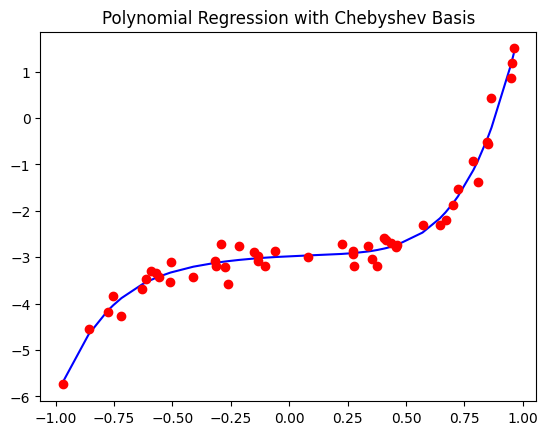

In [2]:
x = np.sort(np.random.uniform(-1, 1, 50))
a = np.random.randint(-3, 3, 6)
y = p.polyval(x, a) + np.random.normal(0, 1, 50)*0.2

model = pr.PolyLeastSquares(5)
model.fit(x, y)
c1 = model.get_coefficients()

model.basis = 'chebyshev'
model.fit(x, y)
c2 = model.get_coefficients()

print('original coefficients:', a)
print('\nmonomial coefficients:', c1)
print('\nchebyshev coefficients:', model.c)
print('\nchebyshev converted to monomial:', c2)
print('\ntotal difference between coefficients:',np.sum(np.abs(c1 - c2)))
plt.plot(x, model.predict(x), 'b', x, y, 'ro')
plt.title('Polynomial Regression with Chebyshev Basis')

The get_coefficients() function used above multiplies through the computed coefficients and adds the polynomials together to give us the monomial coefficients. We see that when using NumPy's built in function there is virtually no difference between the coefficients. That makes sense since in both cases we're using a 5th degree polynomial. Changing basis should have no effect on the exact solution since it's essentially just a change of coordinates, in the same way that picking different directions for the x and y axis in a physics problem doesn't actually change the movement of the elements in the system.

For the next test we'll try usingthe so called "normal equations" where we multiply each side of the overdetermined system of linear equations by the transpose of the data matrix. This method provides the same least squares solution as the QR decomposition used in the NumPy least squares function but the normal equations are generally viewed as a worse solution technique because they require many more floating point operations to reach a solution. 

In [3]:
x = np.sort(np.random.uniform(-2, 2, 100))
a = np.random.randint(-5, 5, 6)
y = p.polyval(x, a) + np.random.normal(0, 1, 100)*0.2

model = pr.PolyLeastSquares(5)
model.fit(x, y)
c1 = model.get_coefficients()

model.basis = 'chebyshev'
model.fit(x, y)
c2 = model.get_coefficients()

print('original coefficients:', a)
print('\nmonomial coefficients:', c1)
print('\nchebyshev converted to monomial:', c2)
print('\ntotal difference between coefficients:',np.sum(np.abs(c1 - c2)))

original coefficients: [ 2  1  0 -3 -4 -5]

monomial coefficients: [ 1.99446601  0.91604071 -0.09477354 -2.96717917 -3.97252691 -4.99950535]

chebyshev converted to monomial: [ 1.99446601  0.91604071 -0.09477354 -2.96717917 -3.97252691 -4.99950535]

total difference between coefficients: 2.2121193765656244e-13


Again we see virtually no difference. Moving to something a bit more interesting we're now going to look at how each basis performs when we switch to gradient descent as the solution method.

Residuals for monomial basis: [1.284657665808913, 5.142256929425779, 1.8689035921276014, 6.5221019005764385]
Residuals for Chebyshev basis: [0.8487405255279649, 3.154326018313608, 0.8925448656712283, 1.2232838666087367]


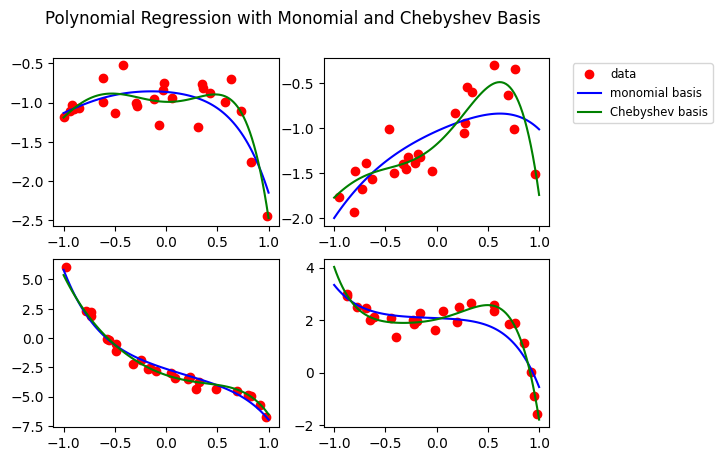

In [4]:
l = -1
r = 1
n = 25
d = 5
m = 4
diff = []
x = []
y = []
y1 = []
y2 = []
r1 = []
r2 = []
res1 = []
res2 = []
z = np.linspace(l, r, 100)

for i in range(4):
    a = np.random.randint(-3, 3, d+1)
    x.append(np.random.uniform(l, r, n))
    y.append(np.polyval(a, x[i]) + np.random.normal(0, 1, n)*0.25)

    model = pr.PolyLeastSquares(degree=d, basis='monomial'
                                , learning_rate=1e-3, max_iterations=10000, tol=0.0)
    model.fit(x[i], y[i], method='gd')
    y1.append(model.predict(z))
    r1.append(model.predict(x[i]))
    res1.append(np.linalg.norm(r1[i] - y[i])**2)

    model.basis = 'chebyshev'
    model.fit(x[i], y[i], method='gd')
    y2.append(model.predict(z))
    r2.append(model.predict(x[i]))
    res2.append(np.linalg.norm(r2[i] - y[i])**2)


print('Residuals for monomial basis:', res1)
print('Residuals for Chebyshev basis:', res2)
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(x[0], y[0],'ro', z, y1[0], 'b', z, y2[0], 'g')
axs[1, 0].plot(x[1], y[1], 'ro', z, y1[1], 'b', z, y2[1], 'g')
axs[0, 1].plot(x[2], y[2], 'ro', label='data')
axs[0, 1].plot(z, y1[2], 'b', label='monomial basis')
axs[0, 1].plot(z, y2[2], 'g', label='Chebyshev basis')
axs[1, 1].plot(x[3], y[3], 'ro', z, y1[3], 'b', z, y2[3], 'g')
axs[0,1].legend(loc='upper right', fontsize='small', bbox_to_anchor=(1.75, 1))
fig.suptitle('Polynomial Regression with Monomial and Chebyshev Basis')
plt.show()

Even though we ran both methods for the same number of sets we see that the Chebyshev method consistently reached a lower sum of square residuals. We can also see this very clearly in the plots, the green lines follow each data set much more closely. This makes sense since it's easier to move when we have an orthogonal basis, since the monomials are each very similar to eachother it's harder to move towards the true least squares solution. Think about two dimensions if your basis consisted of the vectors [1, 0] and [1, 0.001], it's difficult to move from [0, 0] to [0, 1] with those basis vectors.

A common strategy to deal with the issues associated with using a monomial basis in polynomial regression is to normalize the data. Instead of using x, x^2, x^3,... as our regressors we convert use the z-scores of each monomial, 

    (x-mean(x))/sqrt(var(x)), (x^2-mean(x^2))/sqrt(var(x^2)), ...

So now our basis consists of linear transformations of the monomials. This kind of normalization is an option within my PolyLeastSquares class so we can test it to see how it stacks up against the chebyshev basis without normalization.

Residuals for monomial basis: [1.517135594482268, 0.7075337294523449, 0.6541737670652077, 1.1364649990668645]
Residuals for Chebyshev basis: [1.3976866662808916, 0.5905513332655967, 1.0570326501545644, 0.908077671424505]


Text(0.5, 0.98, 'Normalized Monomial vs. Chebyshev Basis')

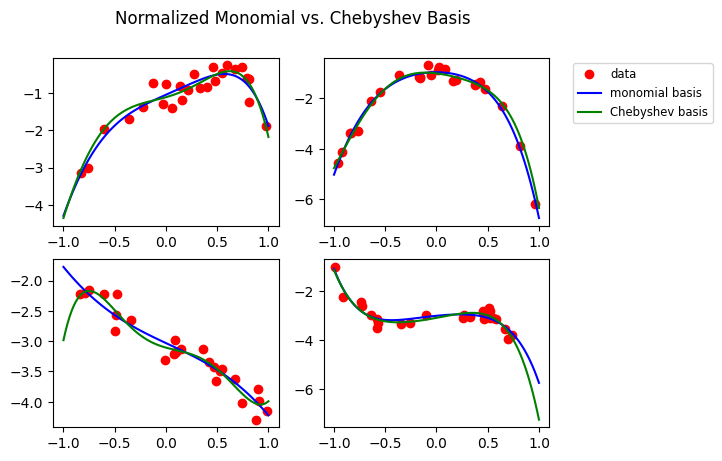

In [5]:
l = -1
r = 1
n = 25
d = 5
m = 4
diff = []
x = []
y = []
y1 = []
y2 = []
r1 = []
r2 = []
res1 = []
res2 = []
z = np.linspace(l, r, 100)

for i in range(4):
    a = np.random.randint(-3, 3, d+1)
    x.append(np.random.uniform(l, r, n))
    y.append(np.polyval(a, x[i]) + np.random.normal(0, 1, n)*0.2)

    model = pr.PolyLeastSquares(degree=d, basis='monomial', learning_rate=1e-3,
                                 max_iterations=10000, tol=0.0, normalize=True)
    model.fit(x[i], y[i], method='gd')
    y1.append(model.predict(z))
    r1.append(model.predict(x[i]))
    res1.append(np.linalg.norm(r1[i] - y[i])**2)

    model.normalize = False
    model.basis = 'chebyshev'
    model.fit(x[i], y[i], method='gd')
    y2.append(model.predict(z))
    r2.append(model.predict(x[i]))
    res2.append(np.linalg.norm(r2[i] - y[i])**2)


print('Residuals for monomial basis:', res1)
print('Residuals for Chebyshev basis:', res2)
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(x[0], y[0],'ro', z, y1[0], 'b', z, y2[0], 'g')
axs[1, 0].plot(x[1], y[1], 'ro', z, y1[1], 'b', z, y2[1], 'g')
axs[0, 1].plot(x[2], y[2], 'ro', label='data')
axs[0, 1].plot(z, y1[2], 'b', label='monomial basis')
axs[0, 1].plot(z, y2[2], 'g', label='Chebyshev basis')
axs[1, 1].plot(x[3], y[3], 'ro', z, y1[3], 'b', z, y2[3], 'g')
axs[0,1].legend(loc='upper right', fontsize='small', bbox_to_anchor=(1.75, 1))
fig.suptitle('Normalized Monomial vs. Chebyshev Basis')

The residuals from these methods appear to be much closer though a sample of 4 tests isnt exactly very scientific. Ive included some results below from a more systematic test. 10,000 random polynomials with noise were generated, gradient descent with a learning rate of 1e-3 was run on each set of test data for 10,000 iterations with both the chebyshev and normalized monomial basis'.  

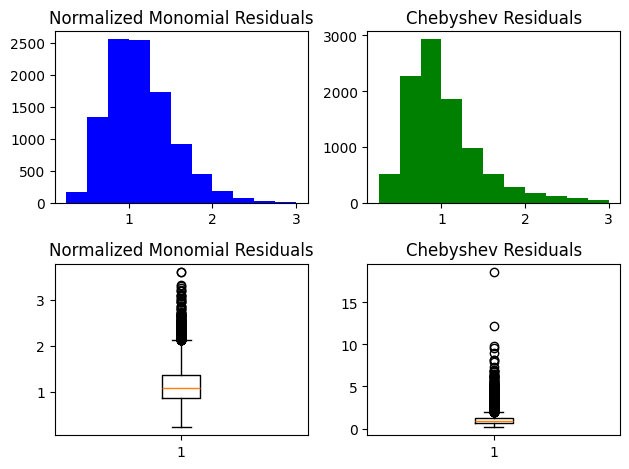

In [6]:
import pandas as pd

bins = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0]
data = pd.read_csv('residuals.csv')

res_m = data['normalized monomial'].to_list()
res_c = data['chebyshev'].to_list()

fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(res_m, bins, facecolor='b')
axs[0, 0].set_title('Normalized Monomial Residuals')

axs[0, 1].hist(res_c, bins, facecolor='g')
axs[0, 1].set_title('Chebyshev Residuals')

axs[1, 0].boxplot(res_m)
axs[1, 0].set_title('Normalized Monomial Residuals')

axs[1, 1].boxplot(res_c)
axs[1, 1].set_title('Chebyshev Residuals')
plt.tight_layout()


The means appear close but the lower tail of the chebyshev is definately heavier. So both tend to reach residuals in the range of [0.75, 1.0]. The higher frequency of outliers with residuals in the 3+ range for the chebyshev method is interesting and also somewhat concernig for the usefulness of that method. Lets print out the summary statistics for the data to take a closer look.

In [7]:
print('quantiles for normalized monomial residuals:', np.quantile(res_m, [0.25, 0.5, 0.75]))
print('quantiles for Chebyshev residuals:', np.quantile(res_c, [0.25, 0.5, 0.75]))

print('\nmean for normalized monomial residuals:', np.mean(res_m))
print('mean for Chebyshev residuals:', np.mean(res_c))

print('\nvariance for normalized monomial residuals:', np.var(res_m))
print('variance for Chebyshev residuals:', np.var(res_c))

quantiles for normalized monomial residuals: [0.85785404 1.08477599 1.36229847]
quantiles for Chebyshev residuals: [0.72573907 0.93348479 1.23917361]

mean for normalized monomial residuals: 1.1426694345544866
mean for Chebyshev residuals: 1.096470802896665

variance for normalized monomial residuals: 0.16097648018108648
variance for Chebyshev residuals: 0.49242399315187624


This confirms what was just stated, the chebyshev method tends to perform better in most cases but has so higher variability due to that larger set out outliers. At this point it seems worth investigating the situations where the performance of the chebyshev basis is much worse, maybe this corresponds to a certain subset of polynomials that we can identify.


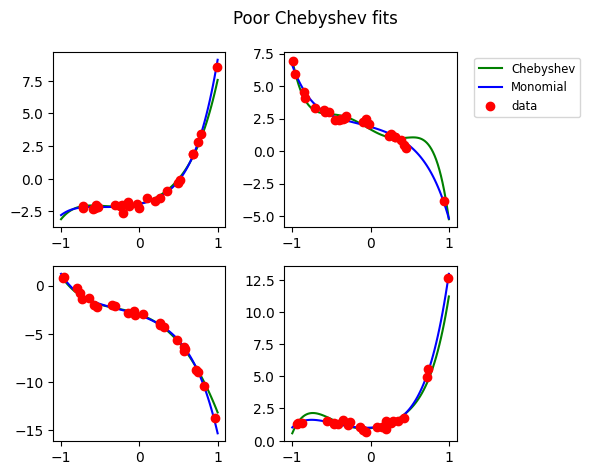

In [8]:
import json
with open('residuals.json') as f:
    data = json.load(f)

outliers = {'origional coefficients': [], 'chebyshev coefficients': [], 'monomial coefficients': [], 'data': [], 'x': []}
for i in range(len(data['data'])):
    if data['chebyshev'][i] > 3.0:
        outliers['origional coefficients'].append(data['origional coefficients'][i])
        outliers['chebyshev coefficients'].append(data['chebyshev coefficients'][i])
        outliers['monomial coefficients'].append(data['monomial coefficients'][i])
        outliers['data'].append(data['data'][i])
        outliers['x'].append(data['x'][i])

x = np.linspace(-1, 1, 100)

fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(x, p.polyval(x, outliers['chebyshev coefficients'][0]), 'g',
            x, p.polyval(x, outliers['monomial coefficients'][0]), 'b')
axs[0, 0].plot(outliers['x'][0], outliers['data'][0], 'ro')
axs[0, 1].plot(x, p.polyval(x, outliers['chebyshev coefficients'][1]), 'g', label='Chebyshev')
axs[0,1 ].plot(x, p.polyval(x, outliers['monomial coefficients'][1]), 'b', label='Monomial')
axs[0, 1].plot(outliers['x'][1], outliers['data'][1], 'ro', label='data')
axs[0, 1].legend(loc='upper right', fontsize='small', bbox_to_anchor=(1.75, 1))
axs[1, 0].plot(x, p.polyval(x, outliers['chebyshev coefficients'][2]), 'g',
            x, p.polyval(x, outliers['monomial coefficients'][2]), 'b')
axs[1, 0].plot(outliers['x'][2], outliers['data'][2], 'ro')
axs[1, 1].plot(x, p.polyval(x, outliers['chebyshev coefficients'][3]), 'g',
            x, p.polyval(x, outliers['monomial coefficients'][3]), 'b')
axs[1, 1].plot(outliers['x'][3], outliers['data'][3], 'ro')
fig.suptitle('Poor Chebyshev fits')
plt.tight_layout()

Only 4 samples but seems like we might have a pattern. lets take a random sample from our chebyshev outliers and just plot the origional curve for all of them

Text(0.5, 1.0, 'Sample of curves with bad chebyshec fits')

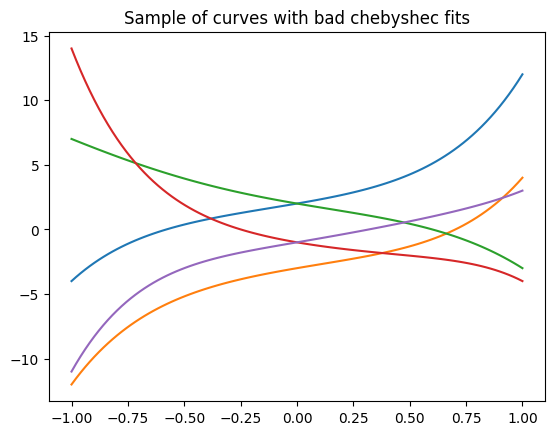

In [21]:
outlier_coeff = np.array(outliers['origional coefficients'])

sample = np.random.choice(len(outlier_coeff), 5, replace=False)
z = np.linspace(-1, 1, 100)

for j in sample:
    plt.plot(z, p.polyval(z, outlier_coeff[j]))
plt.title('Sample of curves with bad chebyshec fits')

Okay, so just running the above cell a bunch of times it seems like that kind of sideways "s" shape is very popular amoung the curves where the chebyshev basis didnt work well. Maybe we can see this more clearly by looking at the distribution of values for each coefficient

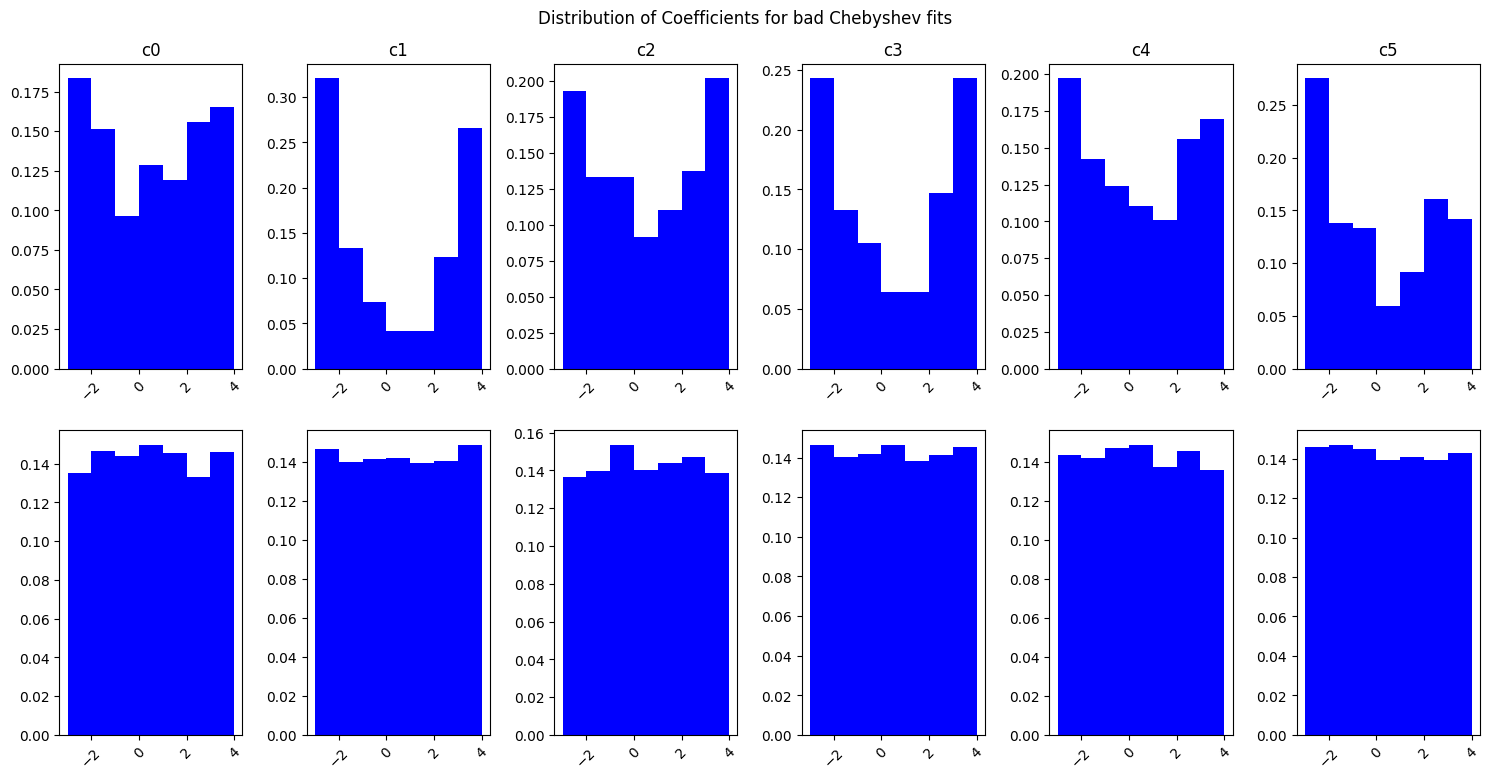

In [10]:
all_coeff = np.array(data['origional coefficients'])
bins = [-3, -2, -1, 0, 1, 2, 3, 4]
#bins = [-3.25, -2.75, -2.25, -1.75, -1.25, -0.75, -0.25, 0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75]
fig, axs = plt.subplots(2, 6, figsize=(15, 8))  # Adjust the figure size if needed
for i in range(6):
    axs[0, i].hist(outlier_coeff[:, i], bins, facecolor='b', density=True)
    axs[0, i].set_title('c{}'.format(str(i)))
    axs[1, i].hist(all_coeff[:, i], bins, facecolor='b', density=True)
    for ax in axs[:, i]:
        for label in ax.get_xticklabels():
            label.set_rotation(45)  # Rotate x-axis labels
fig.suptitle('Distribution of Coefficients for bad Chebyshev fits')
plt.tight_layout()
plt.show()


In the above charts we have the frequency with which each value in the range [-3, 3] appears as the c"i" coefficient, where c0 is the constant coeff, c1 the linear coeff, etc. The top row of histograms are from the chebyshev outliers while the bottom row represents the whole set of 10,000 polynomials that were generated. So we have a kind of "U" shaped distribution on each coefficient for the chebyshev outliers and notably the coefficients on the odd power polynomials seem to have a deeper "U" shape to them. 

It would be good to see if these larger magnitude coefficients tend to appear together in any interesting way. To this end let's look a the covariance and correlation matricies of the outlier coefficients.

In [11]:
np.set_printoptions(precision=2, suppress=True)
print('covariance matrix:\n', np.cov(outlier_coeff.T))
print('\ncorrelation coefficients:\n', np.corrcoef(outlier_coeff.T))

covariance matrix:
 [[ 4.6  -0.32  0.64 -0.05  0.51  0.05]
 [-0.32  6.41  0.4   4.54  0.    3.65]
 [ 0.64  0.4   4.9   0.41  0.79 -0.09]
 [-0.05  4.54  0.41  5.69 -0.29  3.04]
 [ 0.51  0.    0.79 -0.29  4.74 -0.31]
 [ 0.05  3.65 -0.09  3.04 -0.31  5.04]]

correlation coefficients:
 [[ 1.   -0.06  0.13 -0.01  0.11  0.01]
 [-0.06  1.    0.07  0.75  0.    0.64]
 [ 0.13  0.07  1.    0.08  0.16 -0.02]
 [-0.01  0.75  0.08  1.   -0.06  0.57]
 [ 0.11  0.    0.16 -0.06  1.   -0.06]
 [ 0.01  0.64 -0.02  0.57 -0.06  1.  ]]


The covariances cov(c1, c3), cov(c1, c5), and cov(c3, c5) are much larget than the others. So the outliers contain a high percentage of polynomials where several odd powers have larger magnitude coefficients. Larger coefficients on the odd powers would generally lead to a larger range in the data we perform regression on. Just the graphs of the poor chebyshev fits seem to have a larger range that the plots of the other fits. 

Maybe we could get faster convergence by shifting and scaling the chebyshev polynomials based on the range of the given data... 

quantiles for normalized monomial residuals: [0.72 0.93 1.22]
quantiles for Chebyshev residuals: [0.64 0.84 1.23]

mean for normalized monomial residuals: 1.0822465125091711
mean for Chebyshev residuals: 4.040234088295545

variance for normalized monomial residuals: 0.45122642055989964
variance for Chebyshev residuals: 179.57776797732734


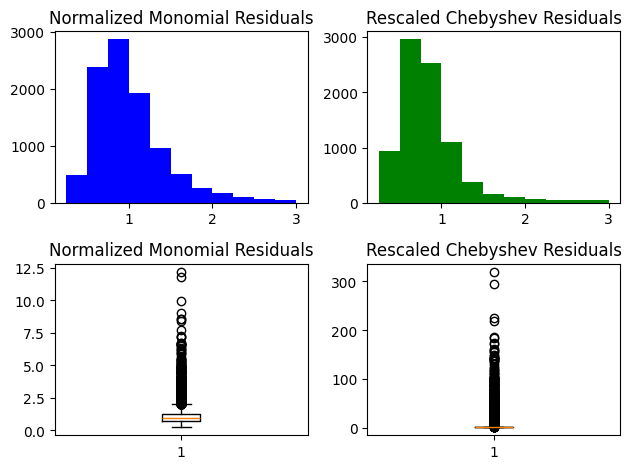

In [17]:
bins = [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0]
data = pd.read_csv('rescale_test_residuals.csv')

res_m = data['normalized monomial'].to_list()
res_c = data['chebyshev'].to_list()

fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(res_m, bins, facecolor='b')
axs[0, 0].set_title('Normalized Monomial Residuals')

axs[0, 1].hist(res_c, bins, facecolor='g')
axs[0, 1].set_title('Rescaled Chebyshev Residuals')

axs[1, 0].boxplot(res_m)
axs[1, 0].set_title('Normalized Monomial Residuals')

axs[1, 1].boxplot(res_c)
axs[1, 1].set_title('Rescaled Chebyshev Residuals')
plt.tight_layout()

print('quantiles for normalized monomial residuals:', np.quantile(res_m, [0.25, 0.5, 0.75]))
print('quantiles for Chebyshev residuals:', np.quantile(res_c, [0.25, 0.5, 0.75]))

print('\nmean for normalized monomial residuals:', np.mean(res_m))
print('mean for Chebyshev residuals:', np.mean(res_c))

print('\nvariance for normalized monomial residuals:', np.var(res_m))
print('variance for Chebyshev residuals:', np.var(res_c))